
=== Improved Dataset Workflow ===
Current working directory: c:\Users\micha\OneDrive\Documents\sit\Y2_T2\Machine_Learning\Project\MLBB
Listings file ready: listings.csv
Original dataset shape: (21058, 75)
First 3 rows:
       id                          listing_url       scrape_id last_scraped  \
0  197677  https://www.airbnb.com/rooms/197677  20241230011552   2024-12-30   
1  776070  https://www.airbnb.com/rooms/776070  20241230011552   2024-12-30   
2  905944  https://www.airbnb.com/rooms/905944  20241230011552   2024-12-30   

        source                                               name  \
0  city scrape                          Oshiage Holiday Apartment   
1  city scrape                             Kero-kero house room 1   
2  city scrape  4F Spacious Apartment in Shinjuku / Shibuya Tokyo   

                                         description  \
0                                                NaN   
1  We have been in airbnb since 2011 and it has g...   
2  NEWLY RENOVATED

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Final columns for modeling:
['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'instant_bookable', 'reviews_per_month', 'amenity_count', 'has_wifi', 'has_kitchen', 'has_pool', 'has_air_conditioning', 'has_security', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'avg_review', 'reviews_ratio', 'host_quality', 'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4', 'loc_5', 'loc_6', 'loc_7', 'loc_8', 'loc_9', 'loc_10', 'loc_11', 'loc_12', 'loc_13', 'loc_14', 'bedrooms_ratio', 'rooms_ratio', 'amenity_density']
Dropped highly correlated features: ['neighbourhood_cleansed_Ota Ku', 'bathrooms avg_review', 'bathrooms host_quality', 'bedr

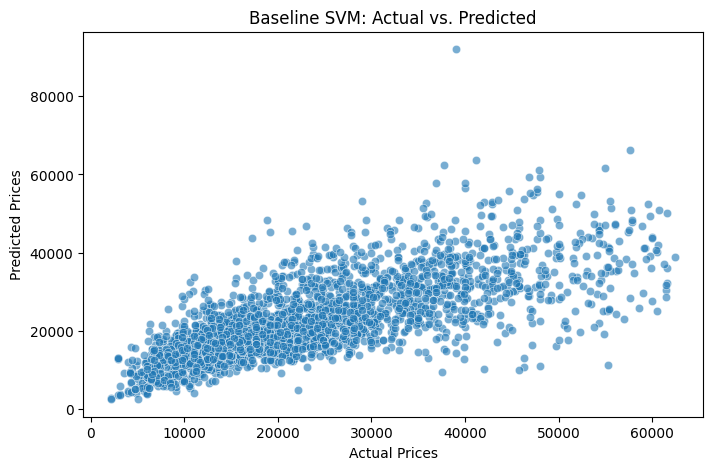

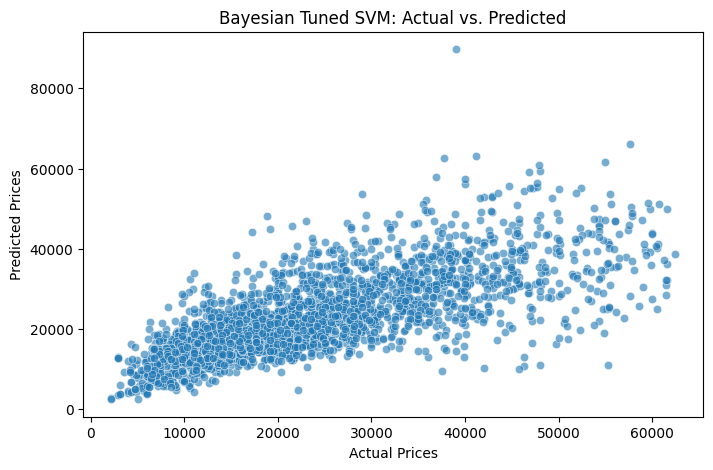

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14732
[LightGBM] [Info] Number of data points in the train set: 11224, number of used features: 150
[LightGBM] [Info] Start training from score 9.909075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

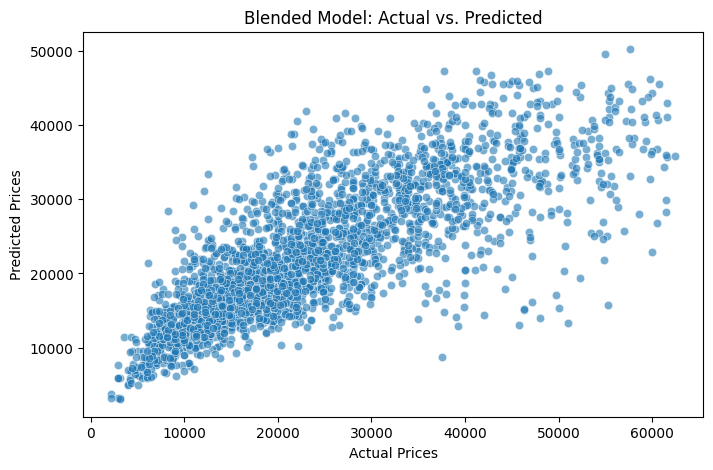

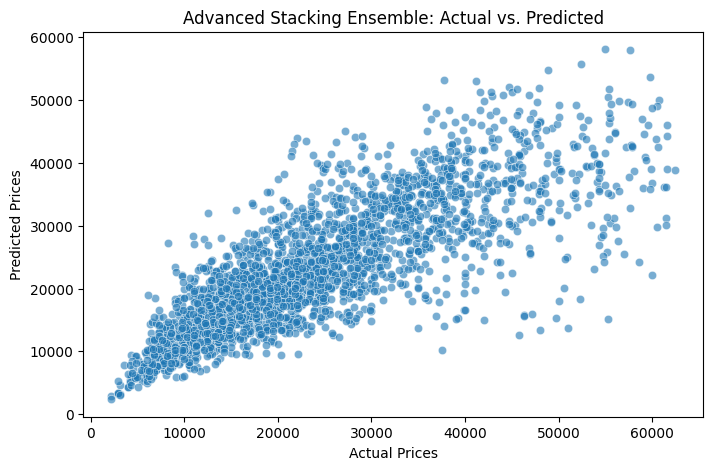


--- Analysis and Findings ---
| Model                                        |   R² Score  |     MAE     |     RMSE    |
|----------------------------------------------|-------------|-------------|-------------|
| Baseline SVM (Linear + Poly)                 | 0.5430    | 5942.0846    | 8401.4406    |
| Bayesian Tuned SVM (Linear + Poly)           | 0.5434    | 5942.1505    | 8398.0265    |
| Blended Model (SVM+XGB+LGB+RF)               | 0.6225    | 5248.0352    | 7636.2313    |
| Advanced Stacking (SVM+XGB+LGB+RF+Ridge)       | 0.6655    | 4817.6610    | 7187.9427    |


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
AirBnB_SVM_Prediction_Improved_Dataset_SelectedModels.py

AirBnB Dataset Prediction with Dataset-Focused Tweaks for Improved R²

Dataset improvements in this version:
  - IQR-based outlier removal on price.
  - Additional feature engineering:
      • host_quality: Combines host response rate, acceptance rate, superhost status, and identity verification.
      • rooms_ratio: Ratio of beds to bedrooms.
      • amenity_density: Ratio of amenity_count to accommodates.
  - Outlier capping (winsorization) on selected numeric features.
  - Finer location clusters with KMeans (15 clusters).
  - Use of RobustScaler and dropping highly correlated features post polynomial expansion.
  
Evaluated models:
  • Baseline SVM (Linear + Polynomial Features)
  • Bayesian Tuned SVM (Linear + Polynomial Features)
  • Blended Model (Ensemble of SVM, XGBoost, LightGBM, and RandomForest)
  • Advanced Stacking (Ensemble of SVM, XGBoost, LightGBM, RandomForest, with Ridge as meta-estimator)
  
For each model, R², MAE, and RMSE are computed.

Dataset source: https://insideairbnb.com/get-the-data/
Note: This version is adapted for the Japan dataset.
Ensure "listings.csv.gz" is in the current working directory.
"""

import os
import gzip
import shutil
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

# For Bayesian tuning (pip install scikit-optimize)
from skopt import BayesSearchCV
from skopt.space import Real

# For XGBoost and LightGBM (pip install xgboost lightgbm)
from xgboost import XGBRegressor
try:
    import lightgbm as lgb
except ModuleNotFoundError:
    print("Warning: lightgbm module not found. To use LightGBM, please install it via 'pip install lightgbm'.")
    lgb = None

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge

def drop_highly_correlated_features(X, threshold=0.95):
    """
    Drops features from dataframe X that have a correlation higher than the given threshold.
    Returns the reduced dataframe and a list of dropped columns.
    """
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(columns=to_drop), to_drop

def cap_outliers(df, columns, lower_quantile=0.01, upper_quantile=0.99):
    """
    Caps outliers for specified columns in df using given quantile thresholds.
    """
    for col in columns:
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        df[col] = df[col].clip(lower, upper)
    return df

def main():
    ##############################
    # Improved Dataset Workflow
    ##############################
    print("\n=== Improved Dataset Workflow ===")
    # 1. Data Extraction
    cwd = os.getcwd()
    print("Current working directory:", cwd)
    compressed_name = 'listings.csv.gz'
    file_name = 'listings.csv'
    if not os.path.exists(file_name):
        with gzip.open(compressed_name, 'rb') as f_in:
            with open(file_name, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    print("Listings file ready:", file_name)

    # 2. Load and Inspect Data
    df = pd.read_csv(file_name)
    print("Original dataset shape:", df.shape)
    print("First 3 rows:")
    print(df.head(3))
    df.info(verbose=True)

    # 3. Data Cleaning
    drop_columns = [
         'id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
         'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
         'host_thumbnail_url', 'host_picture_url', 'host_verifications', 'host_neighbourhood',
         'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic',
         'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review',
         'neighbourhood', 'neighborhood_overview', 'neighbourhood_group_cleansed', 'license', 'picture_url', 'host_id',
         'maximum_nights_avg_ntm', 'has_availability', 'calendar_last_scraped',
         'number_of_reviews_ltm', 'number_of_reviews_l30d',
         'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
         'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
         'name', 'description'
    ]
    df_cleaned = df.drop(columns=drop_columns).dropna()

    # Clean price: remove $ and commas then convert to float
    df_cleaned['price'] = (
        df_cleaned['price']
        .str.replace('$', '', regex=False)
        .str.replace(',', '', regex=False)
        .astype(float)
    )

    # 3a. Outlier Removal using IQR for Price
    Q1 = df_cleaned["price"].quantile(0.25)
    Q3 = df_cleaned["price"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned["price"] >= lower_bound) & (df_cleaned["price"] <= upper_bound)]
    print("Dataset shape after IQR-based outlier removal on price:", df_cleaned.shape)

    # 4. Feature Engineering – Amenities
    df_cleaned['amenities'] = df_cleaned['amenities'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    df_cleaned['amenity_count'] = df_cleaned['amenities'].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    )

    wifi = {"Wifi", "Wi-Fi", "Ethernet connection", "無線lan", "ワイヤレスインターネット"}
    kitchen = {"Kitchen", "Microwave", "Refrigerator", "Stove", "Oven", "BBQ grill", "Coffee maker", "Dining table"}
    pool = {"Pool", "Swimming pool", "Hot tub"}
    air_cond = {"Air conditioning", "Heating", "Ceiling fan", "Indoor Fireplace"}
    security = {"Smoke alarm", "Fire extinguisher", "Carbon monoxide alarm"}
    groups = {
        "has_wifi": wifi,
        "has_kitchen": kitchen,
        "has_pool": pool,
        "has_air_conditioning": air_cond,
        "has_security": security
    }
    for feat, group in groups.items():
        df_cleaned[feat] = df_cleaned.apply(
            lambda row: 1 if (
                isinstance(row['amenity_count'], int) and
                any(item.strip().lower() in {a.lower() for a in group} for item in row['amenities'])
            ) else 0,
            axis=1
        )
    df_cleaned.drop(columns=['amenities'], inplace=True)

    # 5. Process Property & Physical Attributes
    if 'property_type' in df_cleaned.columns:
        df_cleaned.drop(columns=['property_type'], inplace=True)
    if 'room_type' in df_cleaned.columns:
        df_cleaned = pd.get_dummies(df_cleaned, columns=['room_type'], prefix='room_type')

    # Filter out unrealistic bedroom/beds
    df_cleaned = df_cleaned[df_cleaned['bedrooms'] <= 10]
    df_cleaned = df_cleaned[df_cleaned['beds'] <= 10]

    # 6. Process Review Attributes
    review_feats = [
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'
    ]
    df_cleaned['avg_review'] = df_cleaned[review_feats].mean(axis=1)
    df_cleaned.drop(columns=review_feats, inplace=True)

    # 7. Process Booking & Host Attributes
    df_cleaned["instant_bookable"] = df_cleaned["instant_bookable"].map({"t": True, "f": False})
    df_cleaned["reviews_ratio"] = df_cleaned["reviews_per_month"] / (df_cleaned["number_of_reviews"] + 1)

    host_map = {"within an hour": 3, "within a few hours": 2, "within a day": 1, "a few days or more": 0}
    df_cleaned['host_response_time'] = df_cleaned['host_response_time'].map(host_map)
    df_cleaned['host_response_rate'] = df_cleaned['host_response_rate'].str.rstrip("%").astype(float) / 100
    df_cleaned['host_acceptance_rate'] = df_cleaned['host_acceptance_rate'].str.rstrip("%").astype(float) / 100
    df_cleaned['host_is_superhost'] = df_cleaned['host_is_superhost'].map({"t": True, "f": False})
    df_cleaned['host_identity_verified'] = df_cleaned['host_identity_verified'].map({"t": True, "f": False})
    
    # New Feature: Host Quality – combine host response rate, acceptance rate, superhost, and identity verification
    df_cleaned['host_quality'] = (
        (df_cleaned['host_response_rate'] + df_cleaned['host_acceptance_rate']) / 2 +
        df_cleaned['host_is_superhost'].astype(float) * 0.1 +
        df_cleaned['host_identity_verified'].astype(float) * 0.1
    )

    # 8. Process Location Attributes (Clustering)
    loc_df = df_cleaned[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=15, random_state=42)
    df_cleaned['location_cluster'] = kmeans.fit_predict(loc_df)
    df_cleaned = pd.get_dummies(df_cleaned, columns=['location_cluster'], prefix='loc')

    # 9. Additional Feature Engineering
    df_cleaned['bedrooms_ratio'] = df_cleaned['bedrooms'] / (df_cleaned['accommodates'] + 0.1)
    df_cleaned['rooms_ratio'] = df_cleaned.apply(lambda row: row['beds'] / row['bedrooms'] if row['bedrooms'] > 0 else row['beds'], axis=1)
    df_cleaned['amenity_density'] = df_cleaned['amenity_count'] / (df_cleaned['accommodates'] + 0.1)

    # 10. Outlier Capping on Selected Features (Winsorization)
    cap_cols = ['reviews_per_month', 'number_of_reviews', 'reviews_ratio',
                'amenity_count', 'rooms_ratio', 'bedrooms_ratio', 'host_quality']
    df_cleaned = cap_outliers(df_cleaned, cap_cols, lower_quantile=0.01, upper_quantile=0.99)

    # 11. Final Preparation for Modeling
    drop_extra = [
        'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
        'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights'
    ]
    df_cleaned.drop(columns=[col for col in drop_extra if col in df_cleaned.columns], inplace=True)
    print("Final columns for modeling:")
    print(df_cleaned.columns.tolist())

    use_log_target = True
    if use_log_target:
        y = np.log1p(df_cleaned['price'])
    else:
        y = df_cleaned['price']

    X = df_cleaned.drop(columns=['price'])
    X = pd.get_dummies(X, drop_first=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 12. Polynomial Feature Expansion on numeric features
    numeric_cols = [
        'bathrooms', 'bedrooms', 'beds', 'accommodates', 'amenity_count',
        'avg_review', 'number_of_reviews', 'reviews_per_month', 'reviews_ratio',
        'bedrooms_ratio', 'rooms_ratio', 'amenity_density', 'host_quality'
    ]
    available_num = [col for col in numeric_cols if col in X_train.columns]

    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train[available_num])
    X_test_poly = poly.transform(X_test[available_num])
    poly_names = poly.get_feature_names_out(available_num)

    X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_names, index=X_train.index)
    X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_names, index=X_test.index)

    X_train_rest = X_train.drop(columns=available_num)
    X_test_rest = X_test.drop(columns=available_num)

    X_train_final = pd.concat([X_train_rest, X_train_poly_df], axis=1)
    X_test_final = pd.concat([X_test_rest, X_test_poly_df], axis=1)

    # Drop highly correlated features from the final dataset
    X_train_final, dropped_features = drop_highly_correlated_features(pd.DataFrame(X_train_final, index=X_train.index), threshold=0.95)
    X_test_final = pd.DataFrame(X_test_final, index=X_test.index).drop(columns=dropped_features, errors='ignore')
    print("Dropped highly correlated features:", dropped_features)

    # 13. Scaling with RobustScaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_final)
    X_test_scaled = scaler.transform(X_test_final)

    # Helper function to revert target transformation
    def revert_target(y_val):
        return np.expm1(y_val) if use_log_target else y_val

    # -------------------------
    # Model Training & Evaluation
    # -------------------------
    # 1. Baseline SVM (Linear)
    svm_baseline = SVR(kernel='linear', C=1.0)
    svm_baseline.fit(X_train_scaled, y_train)
    y_pred_svm = svm_baseline.predict(X_test_scaled)
    r2_svm = r2_score(revert_target(y_test), revert_target(y_pred_svm))
    mae_svm = mean_absolute_error(revert_target(y_test), revert_target(y_pred_svm))
    rmse_svm = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_svm)))
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=revert_target(y_test), y=revert_target(y_pred_svm), alpha=0.6)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Baseline SVM: Actual vs. Predicted")
    plt.show()

    # 2. Bayesian Tuned SVM (Linear + Poly)
    bayes_params = {
        'C': Real(0.1, 20.0, prior='log-uniform'),
        'epsilon': Real(0.01, 2.0, prior='log-uniform')
    }
    svr_model = SVR(kernel='linear')
    bayes_search = BayesSearchCV(
        svr_model,
        bayes_params,
        n_iter=5,
        cv=2,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42
    )
    bayes_search.fit(X_train_scaled, y_train)
    best_svr = bayes_search.best_estimator_
    y_pred_svr_tuned = best_svr.predict(X_test_scaled)
    r2_svr_tuned = r2_score(revert_target(y_test), revert_target(y_pred_svr_tuned))
    mae_svr_tuned = mean_absolute_error(revert_target(y_test), revert_target(y_pred_svr_tuned))
    rmse_svr_tuned = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_svr_tuned)))
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=revert_target(y_test), y=revert_target(y_pred_svr_tuned), alpha=0.6)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Bayesian Tuned SVM: Actual vs. Predicted")
    plt.show()

    # To build ensemble models, we need to train the component models.
    # 3. XGBoost Tuning (used in ensembles)
    xgb_grid = {
        'n_estimators': [100, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'min_child_weight': [1, 3]
    }
    xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
    xgb_search = RandomizedSearchCV(
        xgb_model,
        xgb_grid,
        n_iter=6,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42
    )
    xgb_search.fit(X_train_scaled, y_train)
    best_xgb = xgb_search.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test_scaled)

    # 4. LightGBM Tuning (used in ensembles)
    if lgb is not None:
        lgb_grid = {
            'n_estimators': [100, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [15, 31],
            'subsample': [0.7, 1.0]
        }
        lgb_model = lgb.LGBMRegressor(random_state=42)
        lgb_search = RandomizedSearchCV(
            lgb_model,
            lgb_grid,
            n_iter=6,
            cv=3,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            random_state=42
        )
        lgb_search.fit(X_train_scaled, y_train)
        best_lgb = lgb_search.best_estimator_
        y_pred_lgb = best_lgb.predict(X_test_scaled)
    else:
        best_lgb = None
        y_pred_lgb = np.zeros(len(y_test))

    # 5. RandomForest Tuning (used in ensembles)
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    y_pred_rf = rf_model.predict(X_test_scaled)

    # 6. Blended Model (SVM + XGBoost + LightGBM + RandomForest)
    y_pred_blend = (
        0.1 * y_pred_svr_tuned +
        0.3 * y_pred_xgb +
        0.3 * y_pred_lgb +
        0.3 * y_pred_rf
    )
    r2_blend = r2_score(revert_target(y_test), revert_target(y_pred_blend))
    mae_blend = mean_absolute_error(revert_target(y_test), revert_target(y_pred_blend))
    rmse_blend = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_blend)))
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=revert_target(y_test), y=revert_target(y_pred_blend), alpha=0.6)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Blended Model: Actual vs. Predicted")
    plt.show()

    # 7. Advanced Stacking Ensemble (SVM + XGBoost + LightGBM + RandomForest with Ridge meta-estimator)
    adv_estimators = [
        ('svm', best_svr),
        ('xgb', best_xgb),
        ('rf', RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42))
    ]
    if best_lgb:
        adv_estimators.append(('lgb', best_lgb))
    adv_stack = StackingRegressor(
        estimators=adv_estimators,
        final_estimator=Ridge(),
        cv=2,
        n_jobs=-1
    )
    adv_stack.fit(X_train_scaled, y_train)
    y_pred_adv_stack = adv_stack.predict(X_test_scaled)
    r2_adv_stack = r2_score(revert_target(y_test), revert_target(y_pred_adv_stack))
    mae_adv_stack = mean_absolute_error(revert_target(y_test), revert_target(y_pred_adv_stack))
    rmse_adv_stack = np.sqrt(mean_squared_error(revert_target(y_test), revert_target(y_pred_adv_stack)))
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=revert_target(y_test), y=revert_target(y_pred_adv_stack), alpha=0.6)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Advanced Stacking Ensemble: Actual vs. Predicted")
    plt.show()

    # -------------------------
    # Final Summary of Results
    # -------------------------
    print("\n--- Analysis and Findings ---")
    print("| Model                                        |   R² Score  |     MAE     |     RMSE    |")
    print("|----------------------------------------------|-------------|-------------|-------------|")
    print("| Baseline SVM (Linear + Poly)                 | {:.4f}    | {:.4f}    | {:.4f}    |".format(r2_svm, mae_svm, rmse_svm))
    print("| Bayesian Tuned SVM (Linear + Poly)           | {:.4f}    | {:.4f}    | {:.4f}    |".format(r2_svr_tuned, mae_svr_tuned, rmse_svr_tuned))
    print("| Blended Model (SVM+XGB+LGB+RF)               | {:.4f}    | {:.4f}    | {:.4f}    |".format(r2_blend, mae_blend, rmse_blend))
    print("| Advanced Stacking (SVM+XGB+LGB+RF+Ridge)       | {:.4f}    | {:.4f}    | {:.4f}    |".format(r2_adv_stack, mae_adv_stack, rmse_adv_stack))

if __name__ == '__main__':
    main()
